<a href="https://colab.research.google.com/github/Renhas/Hyperparameters/blob/main/%D0%9D%D0%98%D0%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Задача

Сравнительный анализ фреймворков для поиска параметров моделей машинного обучения. В ходе работы будут рассмотрены [2 фреймворка](https://www.kaggle.com/code/sivasaiyadav8143/10-hyperparameter-optimization-frameworks)

#Подготовка



Подключим необходимые модули

In [ ]:
! pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.0 MB/s eta 0:00:00


In [ ]:
!pip install optuna

In [ ]:
!pip install hyperopt

In [ ]:
import os
from typing import Tuple, List
import random
import copy
import time

import pickle
import joblib

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler

import optuna
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Датасет

Выбранный <a href="https://www.kaggle.com/datasets/youssefaboelwafa/hotel-booking-cancellation-prediction">датасет</a> содержит информацию о бронировании номеров отеля. В частности он содержит детали бронирования и информацию о клиенте.

Признаки датасета:

* Количество взрослых (number of adults)
* Количество детей (number of children)
* Количество ночей в выходные дни (number of weekend nights)
* Количество ночей в будние дни (number of week nights)
* Тип меню (type of meal):
  * 3 вида планов
  * Не выбрано
* Парковочное место (car parking space) - включена ли плата за парковку в стоимость бронирования
* Тип комнаты (room type) - 6 видов комнат
* Время прибытия (lead time) - количество дней между бронированием и приездом
* Сегмент рынка (market segment type) - тип бронирования, связанный с бронированием:
  * Онлайн (online)
  * Оффлайн (offline)
  * Корпоративный (corporate)
  * Дополнительный (complementary)
  * Авиационный (aviation)
* Повтор (repeated) - повторное ли это бронирование
* Предыдущие отмененные (P-C) - количество отменённых ранее бронирований данным покупателем
* Предыдущие не отменённые (P-not-C) - количество не отменённых ранее бронирований данным покупателем
* Средняя цена (average price)
* Особые пожелания (special requests) - количество особых пожеланий данного покупателя
* Дата бронирования (date of reservation)

Установка модуля для работы с [Kaggle](https://www.kaggle.com/)

In [ ]:
!pip install kaggle --upgrade

Загрузка файла kaggle.json с параметрами подключения к аккаунту

In [ ]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


Скачивание данных и разархивирование

In [ ]:
!kaggle datasets download -d youssefaboelwafa/hotel-booking-cancellation-prediction --force

  0% 0.00/470k [00:00<?, ?B/s]
100% 470k/470k [00:00<00:00, 111MB/s]


In [ ]:
! unzip hotel-booking-cancellation-prediction.zip

Archive:  hotel-booking-cancellation-prediction.zip
  inflating: booking.csv             


In [ ]:
dt = pd.read_csv("booking.csv").set_index("Booking_ID")
dt.index.name = "ID"
dt.head(5)

,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation,booking status
ID,,,,,,,,,,,,,,,,
INN00001,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,10/2/2015,Not_Canceled
INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,11/6/2018,Not_Canceled
INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,2/28/2018,Canceled
INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,5/20/2017,Canceled
INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,4/11/2018,Canceled


##Признаки

In [ ]:
def TE(df: pd.DataFrame, columns: List[str], target: pd.Series) -> Tuple[pd.DataFrame, List[str]]:
  index = df.index
  te = TargetEncoder()
  values = te.fit_transform(df[columns], target)
  labels = te.get_feature_names_in()
  df = df.drop(columns, axis=1)
  df = df.reset_index(drop=True)
  values = values.reset_index(drop=True)
  df = pd.concat([df, values], axis=1)
  df = df.set_index(index)
  return (df, labels)

Столбец таргетных значений преобразуем из строкового типа в числовой

In [ ]:
Y = dt["booking status"].map({"Not_Canceled": 1, "Canceled": 0})
Y.rename({"Booking_ID": "ID"})
Y.name = "Target"
Y.head(5)

ID
INN00001    1
INN00002    1
INN00003    0
INN00004    0
INN00005    0
Name: Target, dtype: int64

Категориальные признаки (тип меню, тип комнаты, тип рынка) преобразуем в числа с помощью TargetEncoder (учитывая "вес" для таргетного значения)

В качестве признаковы возьмём всё, кроме даты регистрации, т.к. работа с такого рода данными требует особого подхода, однако для целей данной работы (сравнения работы фреймворков) это не имеет сильного значения.

In [ ]:
names = {"number of adults": "adults",
         "number of children": "children",
         "number of weekend nights": "weekend",
         "number of week nights": "week",
         "type of meal": "meal",
         "car parking space": "parking",
         "room type": "room",
         "lead time": "time",
         "market segment type": "market",
         "average price": "price",
         "special requests": "requests"}
categorial = ["meal", "room", "market"]
X = dt.drop(["booking status", "date of reservation"], axis=1)
X.rename(names, axis=1, inplace=True)
X, _ = TE(X, categorial, Y)

X.head(5)

,adults,children,weekend,week,parking,time,repeated,P-C,P-not-C,price,requests,meal,room,market
ID,,,,,,,,,,,,,,
INN00001,1,1,2,5,0,224,0,0,0,88.00,0,0.688205,0.677447,0.700503
INN00002,1,0,1,3,0,5,0,0,0,106.68,1,0.668745,0.677447,0.634899
INN00003,2,1,1,3,0,1,0,0,0,50.00,0,0.688205,0.677447,0.634899
INN00004,1,0,0,2,0,211,0,0,0,100.00,1,0.688205,0.677447,0.634899
INN00005,1,0,1,2,0,48,0,0,0,77.00,0,0.668745,0.677447,0.634899


#Модель

Text(0.5, 1.0, 'Target value distribution')

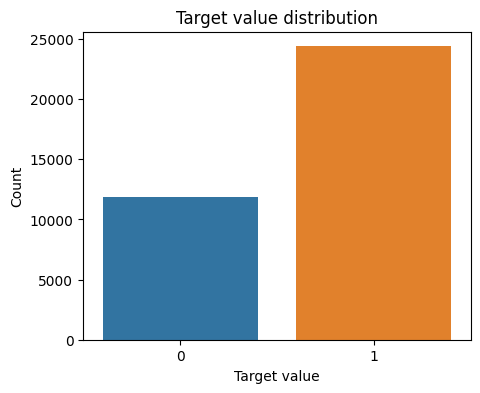

In [ ]:
fig = plt.figure(figsize=(5, 4))
ax = sns.countplot(x=Y.values)
ax.set_xlabel("Target value")
ax.set_ylabel("Count")
plt.title("Target value distribution")

Классы не сбалансированы, поэтому в качестве метрики качества возьмём f1-score, т.к. он устойчив к такого рода случаям.

В качестве исследуемой модели возьмём kNN, т.к. он обладает относительно легкой структурой и интерпретируемостью, а также имеет множество параметров для вариации.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=13)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

In [ ]:
kNN = KNeighborsClassifier()
kNN.fit(X_train, y_train)
print(f"TEST:  F1 -- {f1_score(y_valid, kNN.predict(X_valid))}")

TEST:  F1 -- 0.8895564233503555


#Фреймворки

Для сравнения возьмём фрейморки Optuna и Hyperopt. Варьировать будем:
* число соседей;
* размер листа для внутренних алгоритмов модели;
* параметр p, для вычисления расстояния между точками.

In [ ]:
params = {"n_neighbors": [2, 9],
          "leaf_size": [15, 46],
          "p": [1, 4]}

##Optuna

In [ ]:
def save_trials_optuna(study):
  data = {'n_neighbors': [],
          'leaf_size': [],
          'p': [],
          "duration": [],
          "value": []
          }
  for trial in study.get_trials():
    par = trial.params
    data['n_neighbors'].append(par['n_neighbors'])
    data['leaf_size'].append(par['leaf_size'])
    data['p'].append(par['p'])
    data["duration"].append(trial.duration.total_seconds())
    data["value"].append(trial.value)
  data = pd.DataFrame(data)
  data.to_csv("optuna_res.csv", index=False)

In [ ]:
def objective(trial):
  current_params = {
      "n_neighbors": trial.suggest_int("n_neighbors",
                                       params["n_neighbors"][0],
                                       params["n_neighbors"][1]),
      "leaf_size": trial.suggest_int("leaf_size",
                                     params["leaf_size"][0],
                                     params["leaf_size"][1]),
      "p": trial.suggest_int("p",
                             params["p"][0],
                             params["p"][1]),
      "weights": "distance"
  }
  clf = KNeighborsClassifier(**current_params)
  return cross_val_score(clf, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()

In [ ]:
study = optuna.create_study(direction="maximize", study_name="experimental")
study.optimize(objective, n_trials=50, n_jobs=-1)

[I 2023-12-24 15:25:52,907] A new study created in memory with name: experimental
[I 2023-12-24 15:26:52,988] Trial 1 finished with value: 0.8788879046741803 and parameters: {'n_neighbors': 2, 'leaf_size': 28, 'p': 1}. Best is trial 1 with value: 0.8788879046741803.
[I 2023-12-24 15:27:17,606] Trial 0 finished with value: 0.8912990664716288 and parameters: {'n_neighbors': 5, 'leaf_size': 35, 'p': 3}. Best is trial 0 with value: 0.8912990664716288.
[I 2023-12-24 15:29:11,472] Trial 2 finished with value: 0.8942637433618582 and parameters: {'n_neighbors': 7, 'leaf_size': 20, 'p': 3}. Best is trial 2 with value: 0.8942637433618582.
[I 2023-12-24 15:29:29,438] Trial 3 finished with value: 0.8929143729598426 and parameters: {'n_neighbors': 6, 'leaf_size': 26, 'p': 3}. Best is trial 2 with value: 0.8942637433618582.
[I 2023-12-24 15:29:33,483] Trial 4 finished with value: 0.8955326902855889 and parameters: {'n_neighbors': 8, 'leaf_size': 20, 'p': 2}. Best is trial 4 with value: 0.89553269028

In [ ]:
save_trials_optuna(study)

In [ ]:
joblib.dump(study, "study.pkl")

['study.pkl']

In [ ]:
study.best_params

{'n_neighbors': 9, 'leaf_size': 46, 'p': 1}

In [ ]:
study = joblib.load("study.pkl")
best_params = study.best_params
best_params["weights"] = "distance"
start = time.time()
kNN = KNeighborsClassifier(**study.best_params)
kNN.fit(X_train, y_train)
print(f"TEST:  F1 -- {f1_score(y_valid, kNN.predict(X_valid))}")
print(f"{time.time() - start} секунд")

TEST:  F1 -- 0.8949206666001396
4.759237289428711 секунд


##Hyperopt

In [ ]:
def save_trials_hyper(trials):
  data = {'n_neighbors': [],
          'leaf_size': [],
          'p': [],
          "duration": [],
          "value": []
          }
  for trial in trials:
    par = trial["misc"]["vals"]
    data['n_neighbors'].append(par['n_neighbors'][0])
    data['leaf_size'].append(int(par['leaf_size'][0]))
    data['p'].append(par['p'][0])
    duration = trial['refresh_time'] - trial['book_time']
    data["duration"].append(duration.total_seconds())
    data["value"].append(-1*trial["result"]["loss"])
  data = pd.DataFrame(data)
  data.to_csv("hyperopt_res.csv", index=False)

In [ ]:
def objective_hyper(params):
  clf = KNeighborsClassifier(**params)
  score = cross_val_score(clf, X_train, y_train,
                          cv=5, scoring="f1", n_jobs=-1)
  return {"loss": -score.mean(), "status": STATUS_OK}

In [ ]:
space = {"n_neighbors": hp.randint("n_neighbors",
                                   params["n_neighbors"][0],
                                   params["n_neighbors"][1] + 1),
      "leaf_size": hp.randint("leaf_size",
                              params["leaf_size"][0],
                              params["leaf_size"][1] + 1),
      "p": hp.randint("p",
                      params["p"][0],
                      params["p"][1] + 1),
      "weights": "distance"}
trials = Trials()
best = fmin(objective_hyper, space, tpe.suggest, max_evals=50, trials=trials)

100%|██████████| 50/50 [27:02<00:00, 32.44s/trial, best loss: -0.8973944007233868]


In [ ]:
pickle.dump(trials, open("hyperopt_trials.p", "wb"))

In [ ]:
best

{'leaf_size': 20, 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}

In [ ]:
save_trials_hyper(trials.trials)

In [ ]:
best['leaf_size'] = int(best['leaf_size'])
best["weights"] = "distance"
start = time.time()
kNN = KNeighborsClassifier(**best)
kNN.fit(X_train, y_train)
print(f"TEST:  F1 -- {f1_score(y_valid, kNN.predict(X_valid))}")
print(f"{time.time() - start} секунд")

TEST:  F1 -- 0.9030046380318613
4.342735290527344 секунд


#Анализ

In [ ]:
def find_best(res):
  values = res["value"]
  y = [values[0]]
  for value in values.values[1:]:
    if value > y[-1]:
      y.append(value)
    else:
      y.append(y[-1])
  return y

Восстановление результатов из файла

In [ ]:
optuna_res = pd.read_csv("optuna_res.csv")
hyperopt_res = pd.read_csv("hyperopt_res.csv")

In [ ]:
study = joblib.load("study.pkl")
with open("hyperopt_trials.p", "rb") as f:
  trials = pickle.load(f)

Сравнение средних времён работы каждой итерации поиска

In [ ]:
print(f"Mean duration of Optuna trail: {optuna_res['duration'].mean()}")
print(f"Mean duration of Hyperopt trail: {hyperopt_res['duration'].mean()}")

Mean duration of Optuna trail: 45.94533521999999
Mean duration of Hyperopt trail: 32.43484


In [ ]:
optuna.visualization.plot_optimization_history(study)

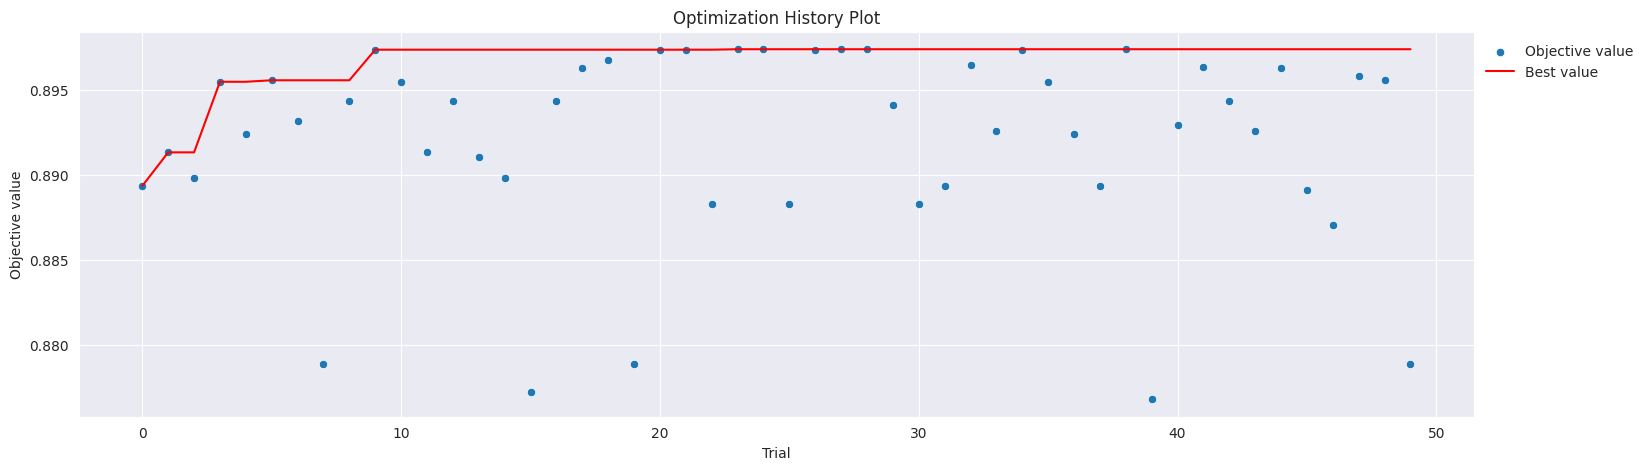

In [ ]:
y_best_hyperopt = find_best(hyperopt_res)
with sns.axes_style("darkgrid"):
  fig = plt.figure(figsize=(18, 5))
  ax = sns.scatterplot(hyperopt_res["value"])
  ax = sns.lineplot(x=hyperopt_res.index, y=y_best_hyperopt, color="r")
  plt.legend(["Objective value", "Best value"], bbox_to_anchor=(1, 1), frameon=False)
  plt.title("Optimization History Plot")
  ax.set_xlabel("Trial")
  ax.set_ylabel("Objective value")
  plt.yticks(np.arange(round(min(hyperopt_res["value"]), 2),
                       max(hyperopt_res["value"]),
                       0.005))

In [ ]:
optuna_max = optuna_res["value"].max()
hyperopt_max = hyperopt_res["value"].max()
print(f"Optuna max value: {optuna_max}")
print(f"Hyperopt max value: {hyperopt_max}")

Optuna max value: 0.8973996690970989
Hyperopt max value: 0.8973944007233868


Сравнения количества дублирующихся значений

In [ ]:
model_parameters = ["n_neighbors", "leaf_size", "p"]

In [ ]:
print(f"Optuna duplicated params: {optuna_res[model_parameters].duplicated().sum()}")
print(f"Hyperopt duplicated params: {hyperopt_res[model_parameters].duplicated().sum()}")

Optuna duplicated params: 10
Hyperopt duplicated params: 6


In [ ]:
print(f"Optuna duplicated values: {optuna_res['value'].duplicated().sum()}")
print(f"Hyperopt duplicated values: {hyperopt_res['value'].duplicated().sum()}")

Optuna duplicated values: 25
Hyperopt duplicated values: 23


In [ ]:
optuna_mask = optuna_res['value'] == optuna_max
hyperopt_mask = hyperopt_res['value'] == hyperopt_max
print(f"Optuna duplicated max value: {optuna_mask.sum()}")
print(f"Hyperopt duplicated max value: {hyperopt_mask.sum()}")

Optuna duplicated max value: 7
Hyperopt duplicated max value: 5


In [ ]:
optuna.visualization.plot_contour(study, params=model_parameters[:2])

In [ ]:
optuna.visualization.plot_contour(study, params=model_parameters[::2])

In [ ]:
optuna.visualization.plot_contour(study, params=model_parameters[1:])

In [ ]:
optuna.visualization.plot_param_importances(study)

Из вышепреведенного графика видно, что наибольшее влияние на качество работы модели оказывает количество соседей. Размер листа оказывает незначителньое значение, а параметр p - практически не влияет на качество классификации.

Всё это справедливо, разумеется, лишь для данного датасета и выбранных диапазонов изменения параметров.